In [1]:
!pip install opensimplex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 5.7 MB/s eta 0:00:00


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
from tqdm import tqdm
from opensimplex import OpenSimplex


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
class MRIDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(256, 256), noise_type=None):

        self.data_dir = data_dir
        self.transform = transform
        self.target_size = target_size
        self.noise_type = noise_type
        self.image_paths = self._load_image_paths()
    
    def _load_image_paths(self):

        image_paths = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith(".png"):
                    image_paths.append(os.path.join(root, file))
        return sorted(image_paths)
    
    def __len__(self):
        return len(self.image_paths)
    
    def _add_noise(self, image, noise_type=None):
        if noise_type is None:
            if self.noise_type == 'coarse':
                # Coarse noise: Low-resolution Gaussian noise
                noise = np.random.normal(0, 0.2, size=(16, 16))
                noise = np.array(Image.fromarray(noise).resize(self.target_size, resample=Image.BILINEAR))
                return image + noise
            elif self.noise_type == 'simplex':
                # Simplex noise: Structured noise
                from opensimplex import OpenSimplex
                simplex = OpenSimplex(seed=42)
                noise = np.zeros(self.target_size)
                scale = 1.0 / 64.0
                for i in range(self.target_size[0]):
                    for j in range(self.target_size[1]):
                        noise[i, j] = simplex.noise2(i * scale, j * scale)
                return image + noise
            else:
                return image
        else :
            if noise_type == 'coarse':
                # Coarse noise: Low-resolution Gaussian noise
                noise = np.random.normal(0, 0.2, size=(16, 16))
                noise = np.array(Image.fromarray(noise).resize(self.target_size, resample=Image.BILINEAR))
                return image + noise
            elif noise_type == 'simplex':
                # Simplex noise: Structured noise
                from opensimplex import OpenSimplex
                simplex = OpenSimplex(seed=42)
                noise = np.zeros(self.target_size)
                scale = 1.0 / 64.0
                for i in range(self.target_size[0]):
                    for j in range(self.target_size[1]):
                        noise[i, j] = simplex.noise2(i * scale, j * scale)
                return image + noise
            else:
                return image

    def __getitem__(self, idx):
        # Load the image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")  # Load as grayscale
        
        # Resize image
        image = image.resize(self.target_size, resample=Image.BILINEAR)
        
        # Convert to NumPy array and normalize to [0, 1]
        image = np.array(image, dtype=np.float32) / 255.0
        
        # Add noise if applicable
        if self.noise_type:
            image = self._add_noise(image)
        
        # Convert back to PIL Image if transform is applied
        if self.transform:
            image = Image.fromarray((image * 255).astype(np.uint8))  # Scale back to [0, 255]
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32)
        
        # Expand to (C, H, W) format (channel dimension)
        image = image.unsqueeze(0) if not self.transform else image
        
        # Label is always 0 (healthy)
        label = 0
        
        return image, label


    def plot_samples(self, num_samples=8):
        if num_samples % 4 != 0:
            raise ValueError("Number of samples must be a multiple of 4.")
        
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 10))
        
        for i in range(num_samples):
            idx = np.random.randint(len(self.image_paths))
            image, label = self[idx]
            
            # Convert tensor to numpy array for plotting
            image_np = image.squeeze(0).numpy()
            
            # Display the image
            axes[i].imshow(image_np, cmap='gray')
            axes[i].set_title(f"Label: {'Healthy'}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()


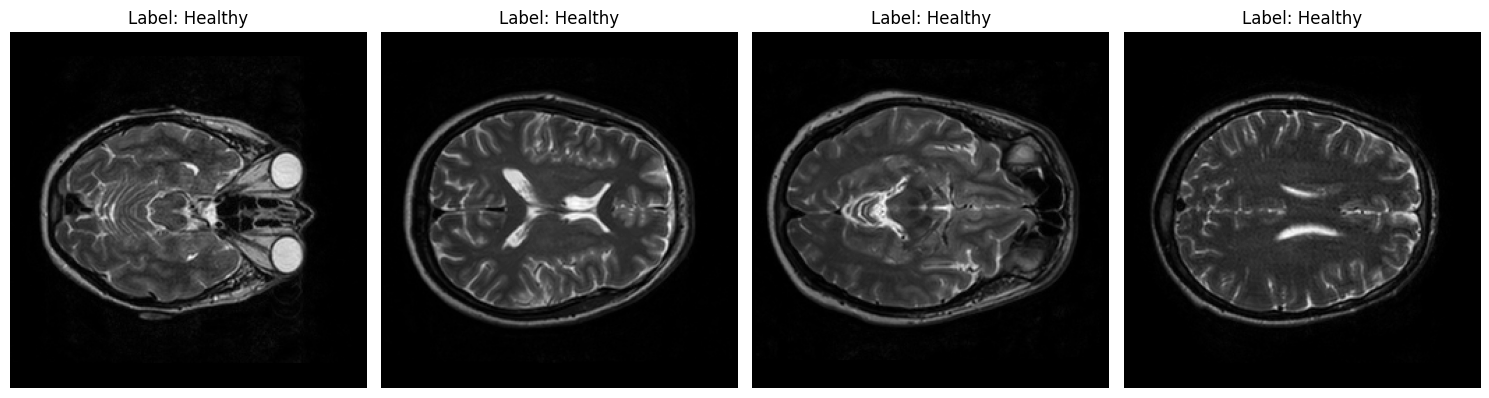

In [5]:
ixit = MRIDataset("/kaggle/input/ixit2-slices", transform)
ixit.plot_samples(4)

In [6]:
class BraTSDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(256, 256)):
        self.data_dir = data_dir
        self.transform = transform
        self.target_size = target_size
        self.image_paths, self.mask_paths = self._load_paths()
    
    def _load_paths(self):
        image_paths = []
        mask_paths = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith("_t2.nii"):
                    image_paths.append(os.path.join(root, file))
                    mask_paths.append(os.path.join(root, file.replace("_t2.nii", "_seg.nii")))
        return sorted(image_paths), sorted(mask_paths)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load T2-weighted image and mask
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()
        
        # Extract the middle slice along the z-axis
        z_index = image.shape[-1] // 2
        image = image[:, :, z_index]  # Extract 2D slice
        mask = mask[:, :, z_index]   # Extract 2D slice
    
        # Normalize image to [0, 1]
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
        # Resize image and mask to target size
        image = resize(image, self.target_size, order=1, mode='reflect', anti_aliasing=True)
        mask = resize(mask, self.target_size, order=0, mode='reflect', anti_aliasing=False)
    
        # Convert NumPy arrays back to PIL images for transformation
        image = Image.fromarray((image * 255).astype(np.uint8))
        mask = Image.fromarray((mask * 255).astype(np.uint8))
    
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else:
            # Convert to tensors
            image = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0)  # Add channel dim
            mask = torch.tensor(np.array(mask), dtype=torch.float32)
    
        return image, mask


    def plot_samples(self, num_samples=4):
        if num_samples % 2 != 0:
            raise ValueError("Number of samples must be even.")
        
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
        
        for i in range(num_samples):
            idx = np.random.randint(len(self.image_paths))
            image, mask = self[idx]
            
            # Convert tensors to numpy arrays for plotting
            image_np = image.squeeze(0).numpy() if isinstance(image, torch.Tensor) else image
            mask_np = mask.squeeze(0).numpy() if len(mask.shape) == 3 else mask
            
            # Display image
            axes[0, i].imshow(image_np, cmap='gray')
            axes[0, i].set_title("T2 Image")
            axes[0, i].axis('off')
            
            # Display corresponding mask
            axes[1, i].imshow(mask_np, cmap='gray')
            axes[1, i].set_title("Segmentation Mask")
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()



In [7]:
data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
dataset = BraTSDataset(data_dir=data_dir, transform=transform)

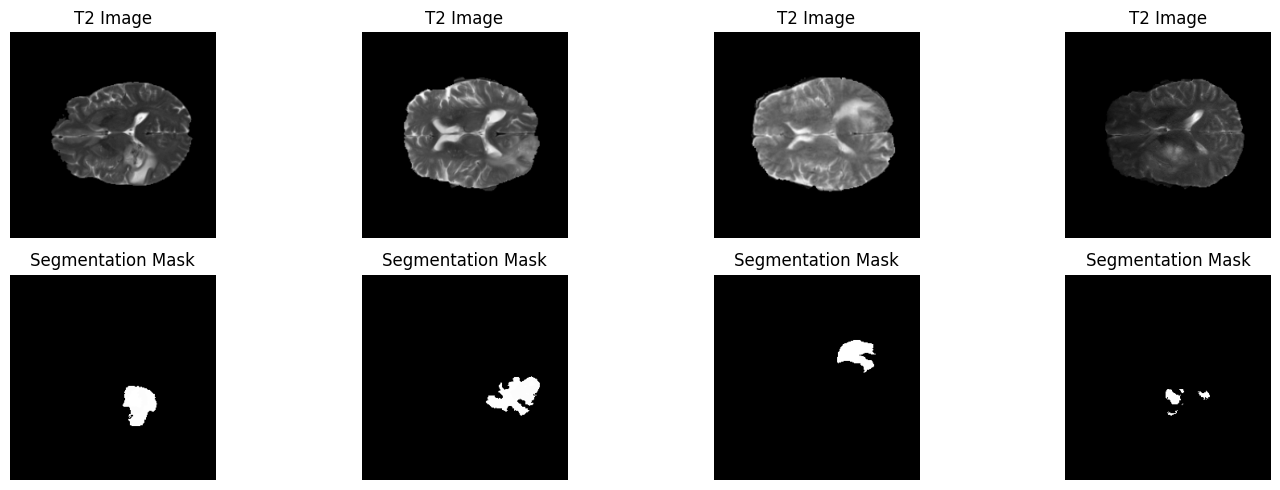

In [8]:
dataset.plot_samples()

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(256 * 16 * 16, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 16 * 16)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 16, 16)
        x = self.deconv(x)
        return x


In [10]:
class TriVAE(nn.Module):
    def __init__(self, latent_dim):
        super(TriVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


In [11]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.L1Loss()(recon_x, x)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

def triplet_loss(anchor, positive, negative, margin=1.0):
    dist_pos = torch.norm(anchor - positive, p=2, dim=1)
    dist_neg = torch.norm(anchor - negative, p=2, dim=1)
    return torch.mean(torch.relu(dist_pos - dist_neg + margin))


In [12]:
def apply_noise(noise_type, images, device):
    if noise_type == 'coarse':
        # Generate coarse noise directly in PyTorch
        noise = torch.randn((images.size(0), 1, 16, 16), device=device) * 0.2  # Low-res Gaussian noise
        noise = torch.nn.functional.interpolate(noise, size=images.shape[2:], mode='bilinear', align_corners=False)
        return images + noise
    elif noise_type == 'simplex':
        # Generate simplex noise directly in PyTorch
        simplex = OpenSimplex(seed=42)
        scale = 1.0 / 64.0
        noise = torch.zeros_like(images, device=device)
        for i in range(images.size(2)):  # Height
            for j in range(images.size(3)):  # Width
                noise[:, :, i, j] = torch.tensor([simplex.noise2(i * scale, j * scale) for _ in range(images.size(0))], device=device)
        return images + noise
    else:
        return images.clone()  # No noise


In [13]:
def train(model, dataloader, optimizer, device, dataset, noise_type='coarse', epochs=10):
    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        print(f"Epoch {epoch + 1}/{epochs}")
        for images, _ in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}"):
            images = images.to(device)
            
            # Generate anchor, positive, and negative samples
            anchor = images
            positive = images.clone()
            
            # Add noise to negative samples explicitly
            negative = apply_noise(noise_type, images, device) 
            
            optimizer.zero_grad()
            
            # Forward pass for each sample
            recon_anchor, mu_anchor, logvar_anchor = model(anchor)
            recon_positive, mu_positive, logvar_positive = model(positive)
            recon_negative, mu_negative, logvar_negative = model(negative)
            
            # Compute losses
            vae_loss_anchor = vae_loss(recon_anchor, anchor, mu_anchor, logvar_anchor)
            vae_loss_positive = vae_loss(recon_positive, positive, mu_positive, logvar_positive)
            vae_loss_negative = vae_loss(recon_negative, negative, mu_negative, logvar_negative)
            t_loss = triplet_loss(mu_anchor, mu_positive, mu_negative)
            
            # Combine losses
            loss = vae_loss_anchor + vae_loss_positive + vae_loss_negative + t_loss
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {total_loss / len(dataloader):.4f}")
    torch.save(model.state_dict(), 'model_final.pth') 
    print("Model saved!")


In [14]:
def evaluate(model, dataloader, device):
    model.eval()
    residual_maps = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            recon_images, _, _ = model(images)
            residual_map = torch.abs(images - recon_images).cpu().numpy()
            residual_maps.append(residual_map)
    return np.concatenate(residual_maps)


In [15]:
train_loader = DataLoader(ixit, batch_size=128, shuffle=True)


In [16]:
latent_dim = 128
model = TriVAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device is : {device}')

device is : cuda


In [17]:
train(model, train_loader, optimizer, device, ixit, noise_type='coarse', epochs=20)

Epoch 1/20


Training Epoch 1: 100%|██████████| 226/226 [04:58<00:00,  1.32s/it]


Epoch [1/20] - Loss: 15.1788
Epoch 2/20


Training Epoch 2: 100%|██████████| 226/226 [03:23<00:00,  1.11it/s]


Epoch [2/20] - Loss: 1.3778
Epoch 3/20


Training Epoch 3: 100%|██████████| 226/226 [03:16<00:00,  1.15it/s]


Epoch [3/20] - Loss: 1.3756
Epoch 4/20


Training Epoch 4: 100%|██████████| 226/226 [03:16<00:00,  1.15it/s]


Epoch [4/20] - Loss: 1.3748
Epoch 5/20


Training Epoch 5: 100%|██████████| 226/226 [03:13<00:00,  1.17it/s]


Epoch [5/20] - Loss: 1.3863
Epoch 6/20


Training Epoch 6: 100%|██████████| 226/226 [03:14<00:00,  1.16it/s]


Epoch [6/20] - Loss: 1.3713
Epoch 7/20


Training Epoch 7: 100%|██████████| 226/226 [03:14<00:00,  1.16it/s]


Epoch [7/20] - Loss: 1.3712
Epoch 8/20


Training Epoch 8: 100%|██████████| 226/226 [03:13<00:00,  1.17it/s]


Epoch [8/20] - Loss: 1.3707
Epoch 9/20


Training Epoch 9: 100%|██████████| 226/226 [03:14<00:00,  1.16it/s]


Epoch [9/20] - Loss: 1.3707
Epoch 10/20


Training Epoch 10: 100%|██████████| 226/226 [03:13<00:00,  1.17it/s]


Epoch [10/20] - Loss: 1.3706
Epoch 11/20


Training Epoch 11: 100%|██████████| 226/226 [03:12<00:00,  1.17it/s]


Epoch [11/20] - Loss: 1.3704
Epoch 12/20


Training Epoch 12: 100%|██████████| 226/226 [03:13<00:00,  1.17it/s]


Epoch [12/20] - Loss: 1.3716
Epoch 13/20


Training Epoch 13: 100%|██████████| 226/226 [03:13<00:00,  1.17it/s]


Epoch [13/20] - Loss: 1.3736
Epoch 14/20


Training Epoch 14: 100%|██████████| 226/226 [03:18<00:00,  1.14it/s]


Epoch [14/20] - Loss: 1.3738
Epoch 15/20


Training Epoch 15: 100%|██████████| 226/226 [03:14<00:00,  1.16it/s]


Epoch [15/20] - Loss: 1.3738
Epoch 16/20


Training Epoch 16: 100%|██████████| 226/226 [03:17<00:00,  1.15it/s]


Epoch [16/20] - Loss: 1.3736
Epoch 17/20


Training Epoch 17: 100%|██████████| 226/226 [03:14<00:00,  1.16it/s]


Epoch [17/20] - Loss: 1.3736
Epoch 18/20


Training Epoch 18: 100%|██████████| 226/226 [03:14<00:00,  1.16it/s]


Epoch [18/20] - Loss: 1.3735
Epoch 19/20


Training Epoch 19: 100%|██████████| 226/226 [03:13<00:00,  1.17it/s]


Epoch [19/20] - Loss: 1.3735
Epoch 20/20


Training Epoch 20: 100%|██████████| 226/226 [03:14<00:00,  1.16it/s]


Epoch [20/20] - Loss: 1.3735
Model saved!


In [18]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.filters import threshold_otsu

# def evaluate_and_visualize(model, dataset, device, num_samples=4):
#     """
#     Evaluate the model on BraTS slices, compute Dice score, and visualize results.
    
#     Args:
#         model (nn.Module): Trained Tri-VAE model.
#         dataset (Dataset): BraTSDataset instance.
#         device (torch.device): Device to run the model on (CPU or GPU).
#         num_samples (int): Number of slices to evaluate and visualize.
#     """
#     model.to(device)
#     model.eval()

#     fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
#     dice_scores = []

#     with torch.no_grad():
#         for i in range(num_samples):
#             # Randomly select a tumor slice
#             idx = np.random.randint(len(dataset))
#             image, mask = dataset[idx]
#             image = image.to(device).unsqueeze(0)  # Add batch dimension

#             # Forward pass through the model
#             recon_image, _, _ = model(image)
#             residual_map = torch.abs(image - recon_image).squeeze(0).cpu().numpy()

#             # Threshold residual map to identify tumor region
#             threshold = threshold_otsu(residual_map)
#             predicted_mask = (residual_map > threshold).astype(np.uint8)

#             # Compute Dice score
#             ground_truth = mask.numpy().astype(np.uint8)
#             intersection = np.sum(predicted_mask * ground_truth)
#             dice = (2.0 * intersection) / (np.sum(predicted_mask) + np.sum(ground_truth) + 1e-6)
#             dice_scores.append(dice)

#             # Visualize results
#             axes[i, 0].imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
#             axes[i, 0].set_title("Input Slice")
#             axes[i, 0].axis('off')

#             axes[i, 1].imshow(recon_image.squeeze(0).cpu().numpy(), cmap='gray')
#             axes[i, 1].set_title("Reconstructed Slice")
#             axes[i, 1].axis('off')

#             axes[i, 2].imshow(residual_map, cmap='hot')
#             axes[i, 2].set_title("Residual Map")
#             axes[i, 2].axis('off')

#             axes[i, 3].imshow(ground_truth, cmap='gray', alpha=0.5, label='Ground Truth')
#             axes[i, 3].imshow(predicted_mask, cmap='jet', alpha=0.5, label='Predicted Mask')
#             axes[i, 3].set_title(f"Tumor Prediction (Dice: {dice:.4f})")
#             axes[i, 3].axis('off')

#     plt.tight_layout()
#     plt.show()

#     print(f"Average Dice Score: {np.mean(dice_scores):.4f}")


In [19]:
# brats_dataset = BraTSDataset(
#     data_dir=data_dir,
#     transform=transforms.Compose([transforms.ToTensor()]),
#     target_size=(256, 256)
# )

# # Evaluate and visualize
# evaluate_and_visualize(model, brats_dataset, device, num_samples=4)


In [20]:
from skimage.filters import threshold_otsu

def evaluate_brats(model, dataset, device, num_patients=100, threshold=0.1, num_samples_to_display=5):
    """
    Evaluate the trained Tri-VAE model on BraTS tumor slices and compute Dice scores.

    Args:
        model (nn.Module): Trained Tri-VAE model.
        dataset (Dataset): BraTSDataset instance.
        device (torch.device): Device to run the model on (CPU or GPU).
        num_patients (int): Number of patients to evaluate.
        threshold (float): Threshold for identifying anomalies in the residual map.
        num_samples_to_display (int): Number of examples to visualize.

    Returns:
        float: Average Dice score across evaluated slices.
    """
    model.to(device)
    model.eval()
    
    dice_scores = []
    samples_to_display = []
    
    with torch.no_grad():
        for idx in range(min(num_patients, len(dataset))):
            # Load image and mask
            image, mask = dataset[idx]
            image = image.to(device).unsqueeze(0)  # Add batch dimension
            
            # Forward pass through the model
            recon_image, _, _ = model(image)
            residual_map = torch.abs(image - recon_image).squeeze(0).cpu().numpy()
            
            # Threshold residual map to identify tumor region
            predicted_mask = (residual_map > threshold).astype(np.uint8)
            
            # Compute Dice score
            ground_truth = mask.numpy().astype(np.uint8)
            intersection = np.sum(predicted_mask * ground_truth)
            dice = (2.0 * intersection) / (np.sum(predicted_mask) + np.sum(ground_truth) + 1e-6)
            dice_scores.append(dice)
            
            # Save a few samples for visualization
            if len(samples_to_display) < num_samples_to_display:
                samples_to_display.append((image.squeeze(0).cpu().numpy(), residual_map, predicted_mask, ground_truth))
    
    # Visualization
    visualize_results(samples_to_display, dice_scores[:num_samples_to_display])
    
    return np.mean(dice_scores)


def visualize_results(samples, dice_scores):
    """
    Visualize input slices, residual maps, predicted masks, and ground truth masks.

    Args:
        samples (list): List of tuples containing (input_slice, residual_map, predicted_mask, ground_truth).
        dice_scores (list): List of Dice scores for the visualized samples.
    """
    num_samples = len(samples)
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
    
    for i, (input_slice, residual_map, predicted_mask, ground_truth) in enumerate(samples):
        input_slice = input_slice.squeeze()
        residual_map = residual_map.squeeze()
        predicted_mask = predicted_mask.squeeze()
        ground_truth = ground_truth.squeeze()
        
        axes[i, 0].imshow(input_slice, cmap='gray')
        axes[i, 0].set_title("Input Slice")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(residual_map, cmap='hot')
        axes[i, 1].set_title("Residual Map")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predicted_mask, cmap='gray', alpha=1)
        axes[i, 2].set_title(f"Predicted Mask (Dice: {dice_scores[i]:.4f})")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(ground_truth, cmap='gray', alpha=1)
        axes[i, 3].set_title("Ground Truth Mask")
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()


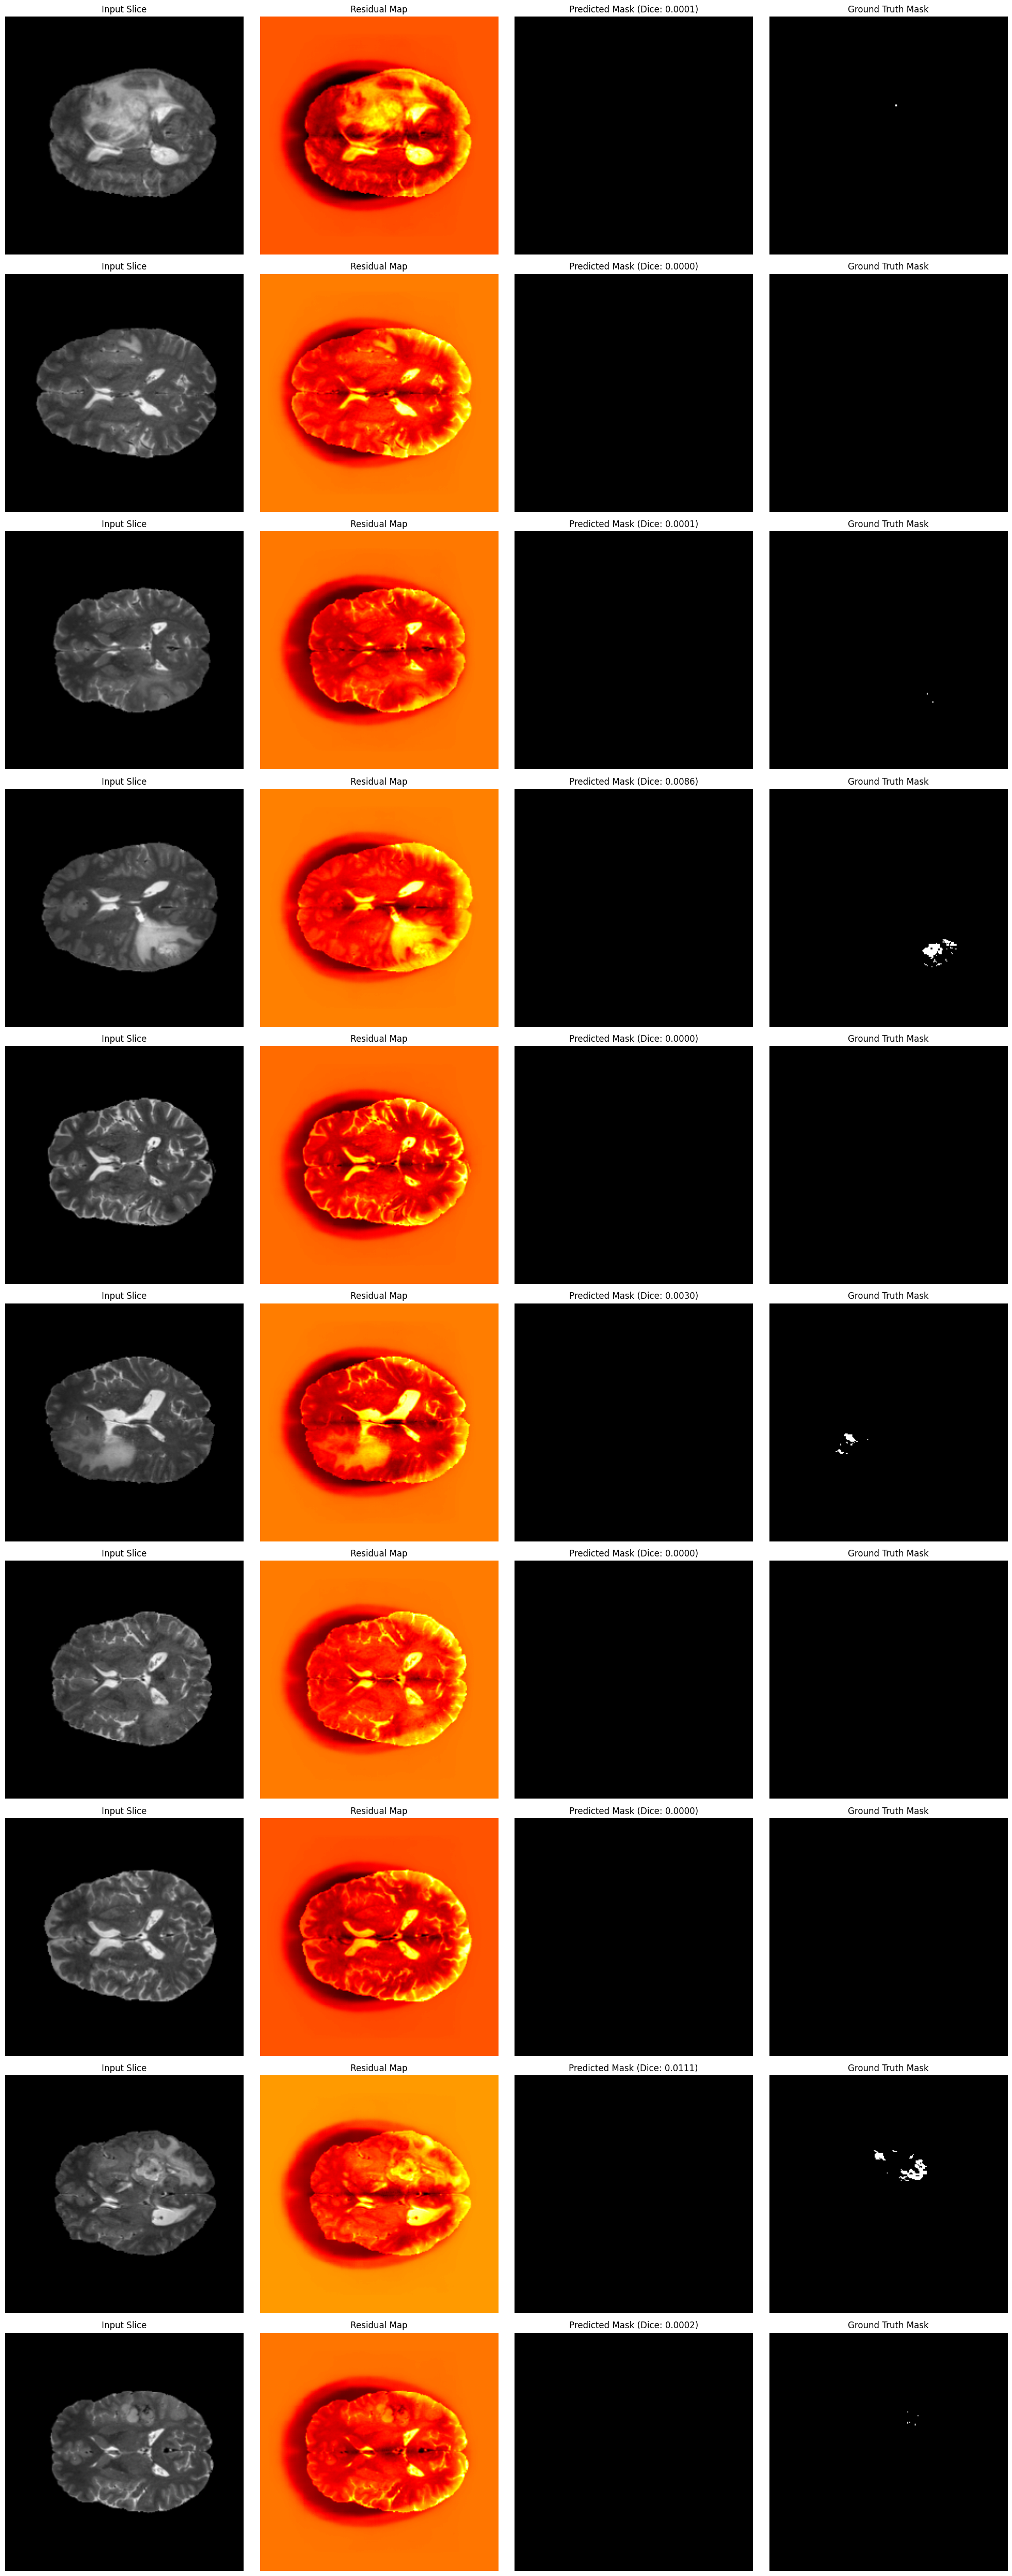

Average Dice Score: 0.0058


In [21]:
# Load BraTS dataset
brats_dataset = BraTSDataset(
    data_dir=data_dir,
    transform=transforms.Compose([transforms.ToTensor()]),
    target_size=(256, 256)
)

# Evaluate the model
average_dice = evaluate_brats(model, brats_dataset, device, num_patients=100, threshold=0.1, num_samples_to_display=10)

print(f"Average Dice Score: {average_dice:.4f}")
